In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# 1. Load Data
X_train = pd.read_csv('cleveland_X_train_processed.csv')
X_test = pd.read_csv('cleveland_X_test_processed.csv')
y_train = pd.read_csv('cleveland_y_train_processed.csv').values.ravel()
y_test = pd.read_csv('cleveland_y_test_processed.csv').values.ravel()

In [ ]:
# 2. Define Optuna Objective Function
def objective(trial):
    # Suggest solvers
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])

    # Handle Solver-Penalty compatibility
    # 'liblinear' supports both 'l1' and 'l2'
    # 'lbfgs' only supports 'l2' (or None)
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'

    # Suggest C (Regularization Strength) and max_iter
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Initialize LR with suggested parameters
    lr = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        max_iter=max_iter,
        random_state=42
    )

    # 10-Fold Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # n_jobs=-1 uses all CPU cores
    scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

    return scores.mean()

In [ ]:
# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-12-04 06:50:59,709] A new study created in memory with name: no-name-90dd94b7-989b-47f3-af4b-8532b2a9aa71
[I 2025-12-04 06:51:01,338] Trial 0 finished with value: 0.5478354978354979 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.0004610228544872809, 'max_iter': 359}. Best is trial 0 with value: 0.5478354978354979.
[I 2025-12-04 06:51:01,398] Trial 1 finished with value: 0.5478354978354979 and parameters: {'solver': 'lbfgs', 'C': 0.0005851401947644428, 'max_iter': 558}. Best is trial 0 with value: 0.5478354978354979.
[I 2025-12-04 06:51:01,457] Trial 2 finished with value: 0.825974025974026 and parameters: {'solver': 'lbfgs', 'C': 20.43790794553298, 'max_iter': 306}. Best is trial 2 with value: 0.825974025974026.
[I 2025-12-04 06:51:01,515] Trial 3 finished with value: 0.8212121212121213 and parameters: {'solver': 'lbfgs', 'C': 11.271756025422418, 'max_iter': 204}. Best is trial 2 with value: 0.825974025974026.
[I 2025-12-04 06:51:01,564] Trial 4 finished with v

In [ ]:
best_params = study.best_params
print(f"Best Parameters found: {best_params}")

Best Parameters found: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.3152418805243669, 'max_iter': 509}


In [ ]:
# 3. Retrain Model with Best Parameters
# Need to reconstruct the penalty logic for the final model
final_solver = best_params['solver']
if final_solver == 'liblinear':
    final_penalty = best_params['penalty']
else:
    final_penalty = 'l2'

best_lr = LogisticRegression(
    solver=final_solver,
    penalty=final_penalty,
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    random_state=42
)
best_lr.fit(X_train, y_train)

LogisticRegression(C=1.3152418805243669, max_iter=509, penalty='l1',
                   random_state=42, solver='liblinear')

In [ ]:
# 4. Evaluate on Training Data
y_train_pred = best_lr.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# 5. Evaluate on Test Data
y_test_pred = best_lr.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [ ]:
# 6. Print Results
print("Training Set Metrics:")
print(f"  Accuracy:  {train_acc * 100:.2f}%")
print(f"  Precision: {train_prec * 100:.2f}%")
print(f"  Recall:    {train_rec * 100:.2f}%")
print(f"  F1 Score:  {train_f1 * 100:.2f}%")

print("Test Set Metrics:")
print(f"  Accuracy:  {test_acc * 100:.2f}%")
print(f"  Precision: {test_prec * 100:.2f}%")
print(f"  Recall:    {test_rec * 100:.2f}%")
print(f"  F1 Score:  {test_f1 * 100:.2f}%")

Training Set Metrics:
  Accuracy:  86.79%
  Precision: 86.96%
  Recall:    83.33%
  F1 Score:  85.11%
Test Set Metrics:
  Accuracy:  83.52%
  Precision: 81.82%
  Recall:    83.72%
  F1 Score:  82.76%


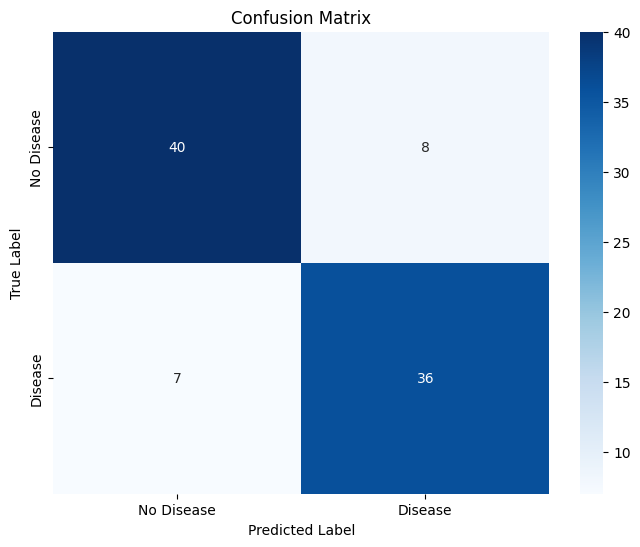

In [ ]:
# 7. Visualization of Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Tuned Logistic Regression Model')
plt.show()